# Load dataset

In [1]:
import pandas as pd
import os 

from data_preprocessing import *

2023-03-01 08:25:59.421324: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
def to_tf_dataset(x, y, y_label='binding',convert_dict=None):
    x = pd.DataFrame(x)
    if convert_dict:
        x = x.replace(convert_dict)
    y = pd.Series(y).reset_index(drop=True)
    full = pd.concat([x, y],axis=1)
    full.columns = [*list(map(str,list(range(1, x.shape[1]+1)))), y_label]
    display(full.shape)
    return tfdf.keras.pd_dataframe_to_tf_dataset(full, label=y_label)


In [ ]:
work_dir = ''
data_dir = work_dir + 'data/experiment2/'

X_df = pd.read_csv(f'{data_dir}HA_X.csv')
y_df = pd.read_csv(f'{data_dir}HA_y.csv')['binding']#.squeeze()

X_df, y_df = subsample_rbd(X_df, y_df)

seq = ['CDRH1_AA', 'CDRH2_AA', 'CDRH3_AA', 'CDRL1_AA', 'CDRL2_AA', 'CDRL3_AA']
cdr_char = 'XEDRKHQNSTPGCAVILMFYW-'
test_size = 0.1

pad_len = []
for c in X_df[seq]:
    pad_len.append(X_df[c].str.len().max())

codes_dict = {i: c for i, c in enumerate(cdr_char)}

[train_set, val_set, test_set], [X_train_id, X_eval_id, X_test_id] = encode(X_df, y_df, cdr_char, test_size, pad_len, le=False, col_names={'id':'Name','sequence':seq})


In [38]:
[train_set_tf, val_set_tf, test_set_tf] = [to_tf_dataset(x, y, convert_dict=codes_dict) for (x,y) in [train_set, val_set, test_set]] ## debug

(train_x, y_train), (val_x, y_val), (test_x, y_test) = [train_set, val_set, test_set]
input_length = train_x.shape[1]

(2298, 100)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(256, 100)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(284, 100)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


# Train

In [5]:
from tensorflow.keras import backend as K
from model_training import *


## deep learning models

### transformer model

In [126]:
K.clear_session()
CDR_model = CDR_model_single(max_length=input_length)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))


In [127]:
eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_x, y_test, X_test_id))
display(eval_df)

True     219
False     65
dtype: int64

,Id,Label,Prediction,Probability
2,C1434,False,True,0.919420
114,C092,False,True,0.712283
126,009_10_2F01,False,True,0.906933
278,K77-1C10,False,True,0.936727
139,045_09_1D03,False,True,0.874635
...,...,...,...,...
66,Mod11_P2_IgG_G11-P1369,True,False,0.117301
63,54.a.62_Heavy,True,False,0.144658
186,COVD21_P2_HC_D10-p1369,True,False,0.343383
156,C812,True,False,0.317221


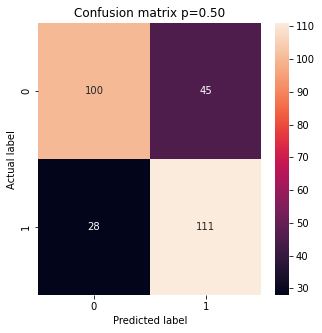

In [9]:
plot_cm(label, pred_bool)

### feed forward network

In [10]:
# dense 

K.clear_session()
CDR_model = CDR_model_dense(max_length=input_length)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))



In [11]:
eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_x, y_test, X_test_id))
display(eval_df)

True     219
False     65
dtype: int64

,Id,Label,Prediction,Probability
982,Mod11_P2_IgG_G7-P1369,False,True,0.990744
998,C2240,False,True,0.899744
69,Mod11_P1_IgG_E7-P1369,False,True,0.811004
1242,C661,False,True,0.941660
1083,MnC4t1p1_A10,False,True,0.668377
...,...,...,...,...
2202,310-18E8,True,False,0.473133
1977,008_10_1F01,True,False,0.270967
1657,236-14-IgG_1A06,True,False,0.435586
2379,H3N2_229-14-2E06_,True,False,0.280511


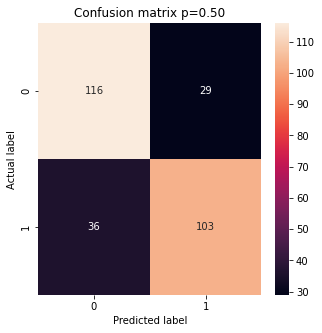

In [12]:
plot_cm(label, pred_bool)

### random forest

In [41]:
# # save model

# model_save_dir = 'models/exp1_random_forest'
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# CDR_model.save(model_save_dir)



# load model

model_load_dir = 'model/exp1_random_forest'
CDR_model = tf.keras.models.load_model(model_load_dir, 
                                             custom_objects={
                                                 'recall_m': recall_m,
                                                 'precision_m': precision_m,
                                                 'f1_score': f1_score
                                             })


2023-03-01 08:35:09.363000: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/yhyeung2/CoV_Encoder_HA/models/20230301/exp1_random_forest/assets


INFO:tensorflow:Assets written to: /home/yhyeung2/CoV_Encoder_HA/models/20230301/exp1_random_forest/assets


In [13]:
def train_tree(CDR_model, train_set_tf, val_set_tf):

    METRICS = [
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'),
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        AUC(name='prc', curve='PR'),  # precision-recall curve
	]

    CDR_model.compile(metrics=METRICS)

    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

    CDR_history=CDR_model.fit(
        x=train_set_tf,
        validation_data=val_set_tf,
        callbacks=callbacks,
        verbose=0
    )

    return CDR_model, CDR_history


In [21]:
# skip if use pre-trained model

K.clear_session()
CDR_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
CDR_model, CDR_history = train_tree(CDR_model, train_set_tf, val_set_tf)


[INFO kernel.cc:727] Start Yggdrasil model training
[INFO kernel.cc:728] Collect training examples
[INFO kernel.cc:389] Number of batches: 36
[INFO kernel.cc:390] Number of examples: 2298
[INFO data_spec_inference.cc:286] 11 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 1 (5 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 7 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 10 (7 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 11 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 12 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 68412 node(s), and 73 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestOptPred" built
[INFO kernel.cc:797] Use fast generic engine


In [42]:

eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_set_tf, y_test, X_test_id))
display(eval_df)



True     242
False     42
dtype: int64

,Id,Label,Prediction,Probability
116,COV2-2031,False,True,0.526666
210,C703,False,True,0.510000
20,C534,False,True,0.526666
74,PZF12_P2_IgG_H2-P1369,False,True,0.536666
124,CQTS129,False,True,0.520000
264,COVD57_P2_HC_E11-1369,False,True,0.526666
150,W85-2C07,True,False,0.316666
154,C1-2E01,True,False,0.480000
162,236-14-IgG_1F03,True,False,0.250000
166,R95-2E10,True,False,0.286666


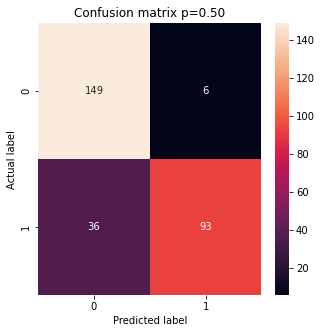

In [43]:
plot_cm(label, pred_bool)

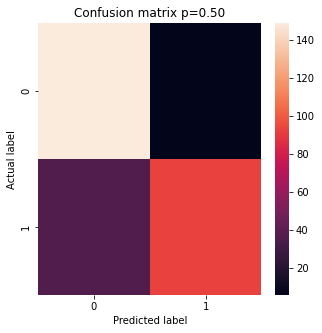

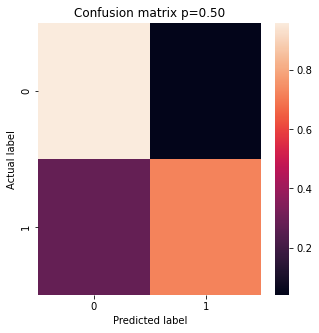

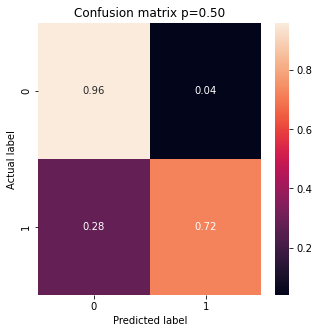

In [44]:
plot_cm(label, pred_bool,annot=False)
plot_cm(label, pred_bool,relative=True,annot=False)
plot_cm(label, pred_bool,relative=True,annot=True)

# Visualize

## extract decision tree rules

In [45]:
from viz_tree import *

In [46]:
# following tfdf library's default
num_trees = 300
max_depth = 16

rule_df = extract_tree(CDR_model, num_trees, max_depth)


100%|███████████████████████████████████████████████████████████████████████████| 300/300 [07:24<00:00,  1.48s/it]


## plot

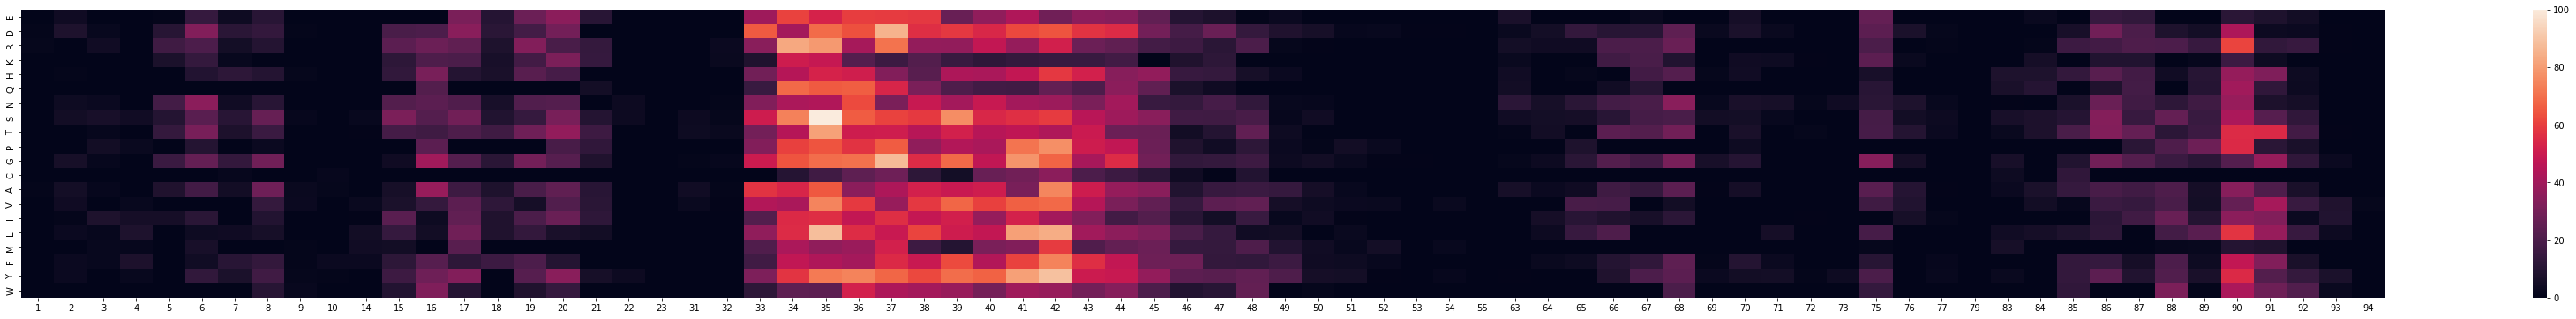

In [47]:
draw_heatmap (rule_df)

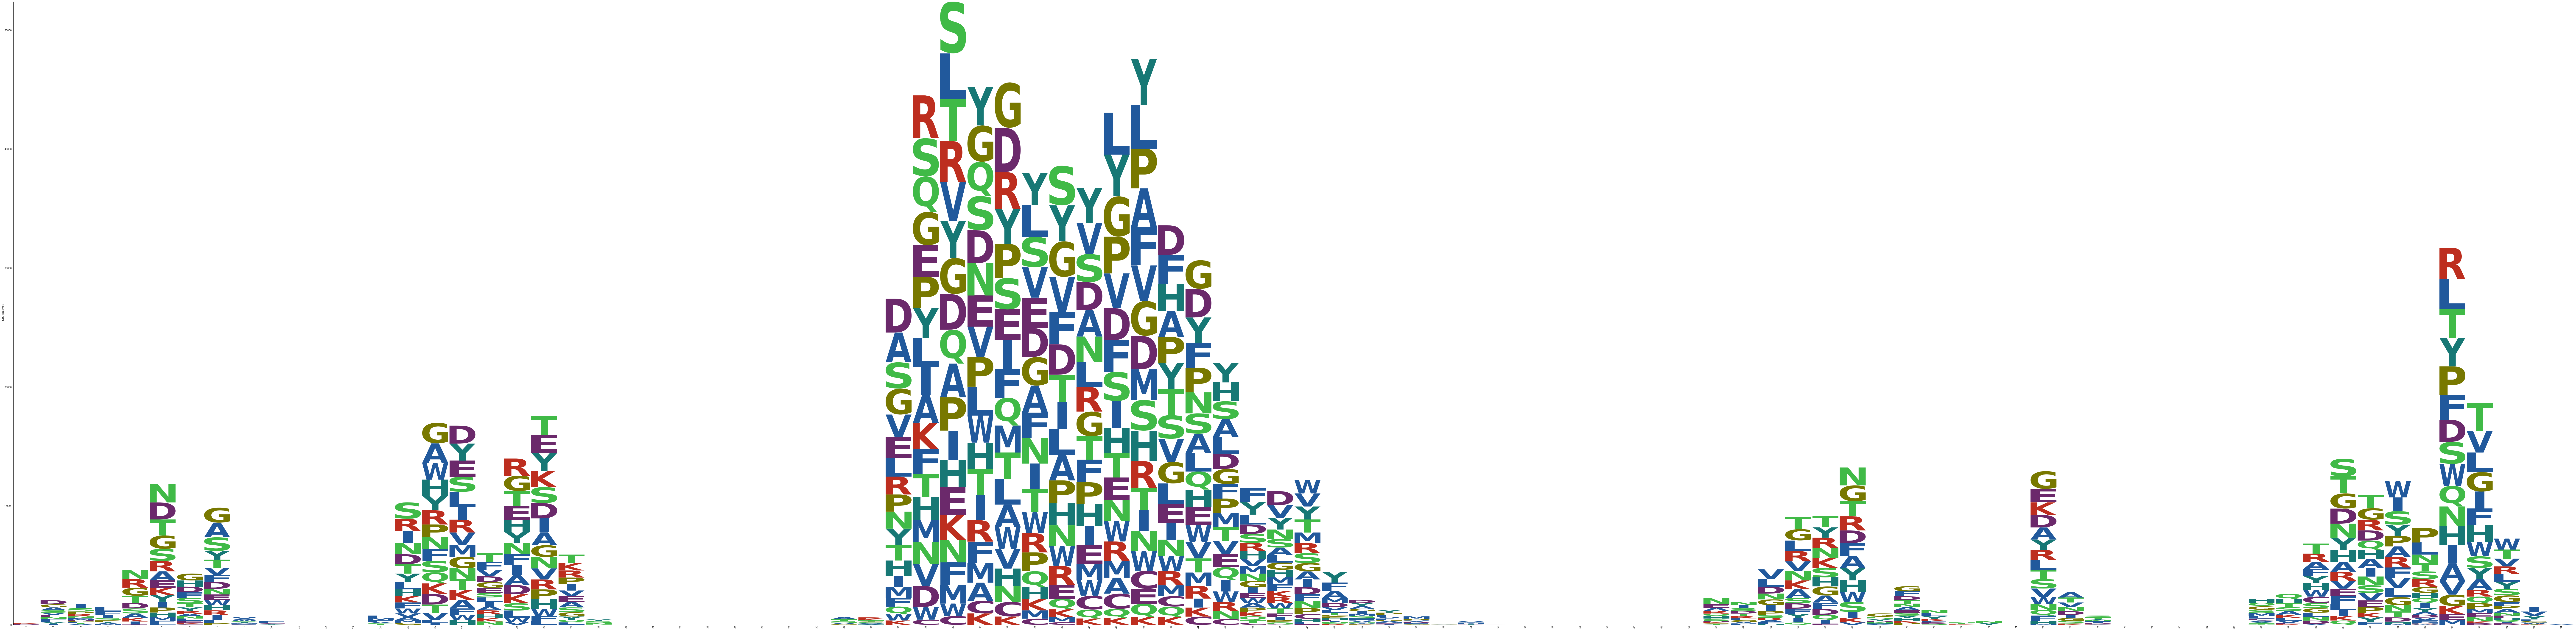

In [49]:
logosequence(rule_df)